In [1]:
%matplotlib inline

from pickle import load

import numpy as np
from scipy import integrate
from scipy.spatial import distance
from scipy.spatial import cKDTree

from nolitsa import dimension

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In [2]:
from source.wishart import Wishart
from source.runge_kutta import RungeKutta
from source.utils import reconstruct_2

In [9]:
import sys
sys.path.insert(0, 'source')
import wishart
import imp
wishart = imp.reload(wishart)
from wishart import Wishart

-----
# MY RUNGE-KUTTA

Manual implementation

**Lorenz system**

Model the chaotic time series as solutions of dynamic Lorenz equation with parameters:  
$ \sigma = 10, \ \beta = 8/3 $  for both cases  
and $r = 26 \ (partly \ chaotic) $ for the first case and $r = 28 \ (fully \ chaotic) $ for second case

\begin{cases} 
              \dot x = \sigma (y - x) \\ 
              \dot y = rx - y - xz \\      
              \dot z = xy - bz
\end{cases}


**Runge-Kutta method 4rth order:**

For the equation $ \dot x = F(x,t) $, we compute slope elements and the average them with weights:

$$ k_{1} = F(t,x) \\
   k_{2} = F(t + \frac {\delta t} {2}, x + \frac {\delta t *k_{1}} {2}) \\
   k_{3} = F(t + \frac {\delta t} {2}, x + \frac {\delta t *k_{2}} {2}) \\
   k_{2} = F(t +  {\delta t}, x + {\delta t *k_{3}})
$$
$$ \\ $$
$$
\\ 
\delta x = \frac {\delta t (k_{1} + 2k_{2} + 2k_{3} + k_{4})} {6} \\
x(t + \delta t) = x(t) + \delta x
$$


## Generation of time series

$\rho = 26$

In [3]:
rk26 = RungeKutta(beta=8/3, rho=26, sigma=10, dt=0.1)
ts26 = rk26.get_series(n_iterations=int(1e6))

$\rho = 28$

In [4]:
rk28 = RungeKutta(beta=8/3, rho=28, sigma=10, dt=0.1)
ts28 = rk28.get_series(n_iterations=int(1e6))

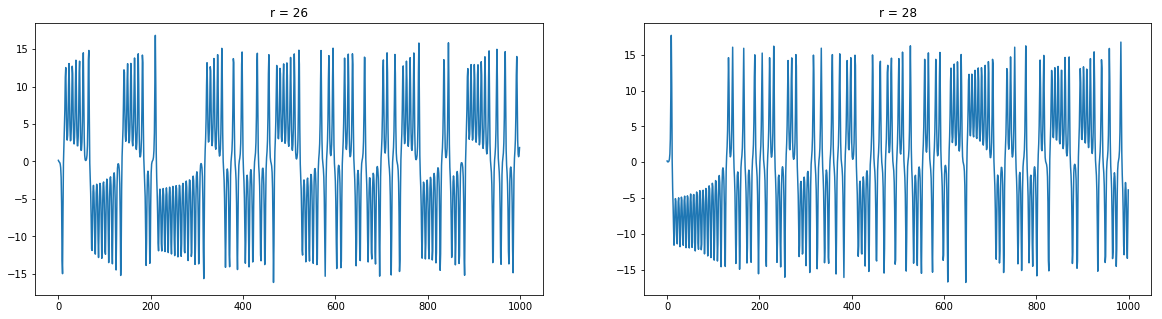

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(20,5);
ax1.plot(ts26[:1000]);
ax1.set_title("r = 26");
ax2.plot(ts28[:1000]);
ax2.set_title("r = 28");

-----
## Largest lyapunov exponent by Rosenstein method  
Advantages: robust to changes in embedding dimension, size of dataset, reconstruction delay and noise level  
Positive lyapunov characteristics points on the chaotic nature of the time series  
**Algorithm:**
- Estimate $m$ using FNN and mean period using FFT (find all harmonics and average them)
- Reconstruct the attractor dynamics $\textbf{X}$ from a single time series:  
$ $$\textbf{X}$ is a matrix, where each row - phase-space vector: $(X_{1},..., X_{M})^{T}$,  
$ $where $X_{i}$ is the state of the system at descrete time $i$.  
$ $For the $N$-point time series $(x_{1},..., x_{N})$, $X_{i}$ is given by $(x_{i}, x_{i+1},..., x_{i + (m-1)})$  
$ $Here $m$ is embedding dimension. So $\textbf{X}$ is $[M \times m]$ matrix and $M=N-(m-1)$
- For each $X_{j}$ in $\textbf{X}$ find nearest neighbor $X_{\hat j}$, so that $d_{j}(0)=min(||X_{j} - X_{\hat j}||)$,  
$ $**But** distance between $j$ and $\hat j$ should be bigger than mean period of the siries(temporal separation)
- For each $X_{j}$ we need to calculate divergency after one tick: $d_{j}(1) = ||X_{j} - X_{\hat j} ||$ and calculate a ratio: $ln \frac {d_{j}(1)} {d_{i}(0)}$
- When we have calculated $ln \frac {d_{j}(1)} {d_{i}(0)}$ for each neighbor's pair, sum them up apply this multiplications/divisions to get
- ~~Least Squares to find best parameters of equation~~. No least square fitting - just average all logarithms: $\lambda_{1} = \sum_{j=1}^{M-1} ln(\frac {d_{j}(1)} {d_{j}(0)}) $

ДОЛЖНЫ ЛИ ПРЕСАТЬСЯ Z - ВЕКТОРА


In [14]:
ts28_reconstructed = reconstruct_2(ts28, m=4)
kdt = lyap._fit_kd_tree(data=ts28_reconstructed)
g = lyap._generator(data=ts28_reconstructed, kdtree=kdt)

In [22]:
l = sum(g)
l / ts28_reconstructed.shape[0] / 0.1

1.012690587199024

Что делать если какая то из дистанций (distance_1, distance_2) оказывается нулевой?

График

In [17]:
lyap = Lyapunov(i=1, m=5, J=0, k=2)
ts_reconstructed = lyap._reconstruct(series_26)
kdt = lyap._fit_kd_tree(data=ts_reconstructed)
g = lyap._generator(data=ts_reconstructed, kdtree=kdt)
print("Lyapunov exponent for r=26:", sum(g) / ts_reconstructed.shape[0])

Lyapunov exponent for r=26: 0.005800204335524006


In [11]:
lyap = Lyapunov(i=1, m=5, J=0, k=2)
# ts_reconstructed = lyap._reconstruct(series_28)
# kdt = lyap._fit_kd_tree(data=ts_reconstructed)
# g = lyap._generator(data=ts_reconstructed, kdtree=kdt)
# print("Lyapunov exponent for r=28:", sum(g) / ts_reconstructed.shape[0])

-----
## Wishart algorithm

The goal is to cluster *z-vectors*

The defenetion of significant cluster $\Omega^{l}$ is: $max\{|p(x_{i}) - p(x_{j})|, \forall i,j\in\Omega^{l} \} \geq h$ where $p(x_{i})=\frac {k}{NV_{k}(x)}$

- Magicly choose the *k* parameter
- For each point find *k* nearest neighbors and calculate distance for k-th nearest neighbor (the sphere radius)
- After constructing the list $K$ of format 

     $$\{x_{1}:[neighbor^{1}_{1},... , neighbor^{1}_{k}, ]\}$$
     $$\{x_{2}:[neighbor^{2}_{1},... , neighbor^{2}_{k}, ]\}$$
     $$ ... $$
     $$\{x_{N}:[neighbor^{N}_{1},... , neighbor^{N}_{k}, ]\}$$
The list must be sorted by the distance to the k-th nearest neigbor. Formally, we name this list a graph $G(Z_{n}, U_{n})$, where $Z_{n}$ are all verticies-neighbors $x_{i}$ and $U_{n}=\{(i,j):d(x_{i}, x_{j}) \leq d_{k}(x_{i}), i \neq j\} $


- After that we launch a cycle on the sorted list of vertices and at each step execute these:
  - Form a new graph $G(Z_{i}, U_{i})$, where $Z_{i} = \{x_{i}, i=\overline{1,...i}\}$ and $U_{i}$ is the sub-entity of $U_{n}$ vergies which are connected to $Z_{i}$. Define connections of the new vertex as edges between new vertex and verticies $Z_{i} \cap K(i)$ 
  - Then, we apply one of the these rules:
    - case $x_{i}$ is isolated: create a new cluster out of it and move on to the next point
    - case $x_{i}$ is only connected to cluster $l$ then:
      - case $l$ is completed, then assign $x_{i}$ to zero cluster
      - case $l$ is not completed, then assign $x_{i}$ to it
    - case $x_{i}$ is connected to several clusters $l_{1},..., l_{t}$
      - case all clusters are completed, then assign $x_{i}$ to zero cluster
      - case number of significant clusters $z(h) \leq t$
        - case $z(h) > 1$ or $l_{1}=0$, then assign  $x_{i}$ to zero cluster, mark significent clusters as completed, and delete all not significant classes
        - case $z(h) \leq 1$ and $l_{1} > 0$, then merge $l_{2},..., l_{t}$ into $l_{1}$
       


Главный вопрос - нужно ли соединяться нулевые вершины??  
Вопрос - в случае объединения классов, нужно ли объединять свормированные классы?

In [11]:
with open("source/data/ts28_reconstructed.npy", "rb") as f:
    reconstructed_28 = np.load(f) 
    length = reconstructed_28.shape[0]
    train_length = length // 3 * 2
    reconstructed_28_train = reconstructed_28[:train_length]
    reconstructed_28_test = reconstructed_28[train_length:]
with open("source/data/ts28.npy", "rb") as f:
    ts_28 = np.load(f) 
    length = ts_28.shape[0]

In [12]:
DIR_PROJECT = "/Users/waryak/Documents/HSE/MastersDiploma"
DIR_DATA = DIR_PROJECT + "/data"
with open(DIR_DATA + "/wishart_model_9_0.005.pkl", "rb") as f:
    model_9_005 = load(f)    
with open(DIR_DATA + "/wishart_model_9_0.01.pkl", "rb") as f:
    model_9_01 = load(f)
with open(DIR_DATA + "/wishart_model_9_0.05.pkl", "rb") as f:
    model_9_05 = load(f)
with open(DIR_DATA + "/wishart_model_9_0.1.pkl", "rb") as f:
    model_9_1 = load(f)
with open(DIR_DATA + "/wishart_model_10_0.1.pkl", "rb") as f:
    model_10_1 = load(f)
with open(DIR_DATA + "/wishart_model_10_0.05.pkl", "rb") as f:
    model_10_05 = load(f)
with open(DIR_DATA + "/wishart_model_10_0.01.pkl", "rb") as f:
    model_10_01 = load(f)

In [13]:
model_9_005._form_cluster_centers(data=reconstructed_28[:666660], reconstruction_shape=5)

In [14]:
model_9_005._cluster_kdtree(n_lags=4)

In [35]:
predictions = []
for zvector in reconstructed_28_test:
    p = model_9_005.predict(data=zvector[:-1])
    if np.isnan(p)
    predictions.append(p)

In [55]:
np.isnan(predictions[2])

True

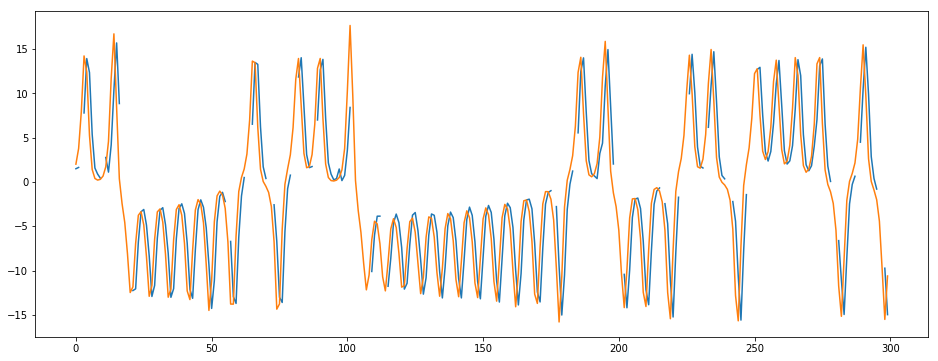

In [59]:
plt.figure(figsize=(16, 6))
plt.plot(list(range(300)), predictions[:300], list(range(300)), ts_28[-333333:-333033])

In [47]:
predictions.append

nan

In [30]:
predictions = []
for i, zvector in zip(range(333333), reconstructed_28_test):
    for j in range(10):
        p = model_9_005.predict(data=zvector)
        if p 
        zvector = zvector[1:]
        zvector 
        pass
        

In [32]:
a = np.array([1,2,3,4])
a[1:]

AttributeError: 'numpy.ndarray' object has no attribute 'pop'

In [17]:
len(predictions)

333333

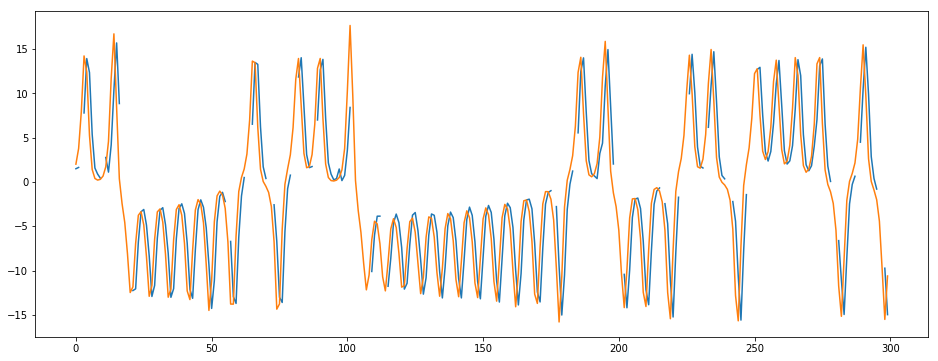

In [28]:
plt.figure(figsize=(16, 6))
plt.plot(list(range(300)), predictions[:300], list(range(300)), ts_28[-333333:-333033])

In [19]:
ts_28[-333333:].shape

(333333,)

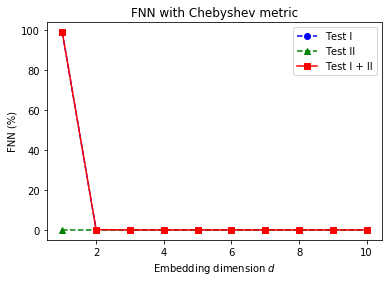

In [91]:
# Generate data.
# x = np.random.normal(size=5000)
dim = np.arange(1, 10 + 1)

plt.figure(1)
f1, f2, f3 = dimension.fnn(series_28[:100000], tau=1, dim=dim, window=10, metric='euclidean')
plt.title(r'FNN with Chebyshev metric')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
plt.legend()

# plt.figure(2)
# f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=0, metric='euclidean')
# plt.title(r'FNN with Euclidean metric')
# plt.xlabel(r'Embedding dimension $d$')
# plt.ylabel(r'FNN (%)')
# plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
# plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
# plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
# plt.legend()

# plt.figure(3)
# f1, f2, f3 = dimension.fnn(x, tau=1, dim=dim, window=0, metric='cityblock')
# plt.title(r'FNN with cityblock (Manhattan) metric')
# plt.xlabel(r'Embedding dimension $d$')
# plt.ylabel(r'FNN (%)')
# plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
# plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
# plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II')
# plt.legend()

# plt.show()

In [10]:
from nolitsa import lyapunov
lyapunov_26 = lyapunov.mle_embed(series_26[:100000], dim=[5], tau=13, maxt=300, window=60)[0]
lyapunov_28 = lyapunov.mle_embed(series_28[:100000], dim=[5], tau=13, maxt=300, window=60)[0]

In [213]:
x, dim=[1], tau=1, window=10, maxt=500,
              metric='euclidean', maxnum=None, parallel=True):

-1.711725320830755

###### 2. Construct an array with indencies to the nearest neighboors and distances to them